In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib widget

In [2]:
from pprint import pprint
from copy import copy
import time
import warnings
from itertools import cycle, islice

from astropy.stats import gaussian_sigma_to_fwhm
from astropy.coordinates import SkyCoord, search_around_sky
from astropy.nddata import Cutout2D
from astropy.table import Table, hstack, vstack, unique
from astropy.wcs import wcs
from astropy.visualization.wcsaxes.frame import EllipticalFrame
from astropy.visualization.wcsaxes import SphericalCircle
from astropy import units as uu
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib import cm, colorbar, colors
from matplotlib.colors import LogNorm
import matplotlib.markers as mmarkers
import matplotlib.font_manager as fm
from matplotlib.patches import Circle
from mpl_toolkits.axes_grid1.anchored_artists import AnchoredSizeBar
import numpy as np

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler

from vasca.field import Field
from vasca.utils import extr_value

In [4]:
"""
list of fields
2552663716076191744 NGS 32 visits
2424979629631602688 MIS 5 visits
2508155485249601536 DIS 5 visits
6388191295067652096 NGC4993-GW170817 2 visits

TDS fields
2605053246158405632 PS_COSMOS_MOS23 DIS 29 visits 
2593653509626789888 PS_CDFS_MOS00 DIS 114 visits 
2594075722091855872 PS_CDFS_MOS06 DIS 29 visits 
2607375414741434368 PS_GROTH_MOS06 DIS 18 visits 
"""

# filed ID
parobs_id = 6388191295067652096

# initialize field analysis
gf = Field(parobs_id, refresh=False, verbose=True)

[Field._load_visits]  Loading GALEX visits table.
[Field._load_visits]  Generating healpix map. Pixel diameter: 0.057 deg deg / 206.1 arcsec arcsec. N_pix: 12582912, N_side: 1024.
[Field._load_coadd]  Loading GALEX coadd table.
[Field._load_archive_products] Loading GALEX data products.
[Field._load_archive_products] Opening catalog files and NUV intesity maps.
[Field._source_match] Matching visits to coadd sources.
[Field._collect_metadata] Report: GALEX field data. ID: 6388191295067652096. Total number of visits 2 from 1 survey(s): AIS(2). Average NUV exposure time: 101.5 s ± 26.5 s. Average time between visits: 336.0 d ± 0.0 d. Averge field center variation: 0.01 deg.


In [5]:
def get_filtered_mcat(
    mcat_name,
    columns,
    cuts,
    add_galactic=True,
):
    """
    Reduces an mcat table according to requested columns and cuts.
    """

    s2n = cuts["s2n"]
    r_fov = cuts["r_fov"]
    mag_upper_lim = cuts["mag_upper_lim"]
    mask = gf._get_mcat_sel(
        mcat_name=mcat_name,
        s2n_cut=s2n,
        fov_cut=r_fov,
        mag_upper_lim_cut=mag_upper_lim
    )
    # filterd catalog table
    tt_mcat = gf.dd_mcats[mcat_name][mask][columns]
    # add equatorial coords
    pos = SkyCoord(tt_mcat["glon"], tt_mcat["glat"], frame="galactic").transform_to("icrs")
    tt_mcat["ra"] = pos.transform_to("icrs")[:].ra
    tt_mcat["dec"] = pos.transform_to("icrs")[:].dec
    
    return tt_mcat

In [6]:
# filter coadd catalog
coadd_keys = [
    "ggoid_dec",
    "glon",
    "glat",
    "nuv_mag",
    "nuv_magerr",
    "nuv_s2n",
    "fov_radius",
    "chkobj_type",
    "nuv_artifact",
    "nuv_poserr",
    "NUV_CLASS_STAR",
]
dd_cuts_coadd = {
            "s2n": 2,
            "r_fov": 0.6,
            "mag_upper_lim": 1,
        }

# filter visit catalogs
visits_list = list(gf.dd_ids.keys())[1:] # names of the visits fields
visit_keys = [ 
    "ggoid_dec",
    "glat",
    "glon",
    "nuv_poserr",
    "nuv_mag",
    "nuv_magerr",
    "nuv_s2n",
    "nuv_artifact"
]
dd_cuts_visit = {
            "s2n": 2,
            "r_fov": 0.6,
            "mag_upper_lim": 1,
        }

# vertical stack of all visit sources
tt_mcat_visits = vstack([get_filtered_mcat(visit, visit_keys, dd_cuts_visit) for visit in visits_list])
# coadd sources for comparison
tt_mcat_coadd = get_filtered_mcat("coadd", coadd_keys, dd_cuts_coadd)

# add nearest neighbor distance
pos_visit = SkyCoord(tt_mcat_visits["glon"], tt_mcat_visits["glat"], frame="galactic")
pos_coadd = SkyCoord(tt_mcat_coadd["glon"], tt_mcat_coadd["glat"], frame="galactic")
tt_mcat_visits["idx_nearest"], tt_mcat_visits["d_nearest"], _ = pos_visit.match_to_catalog_sky(pos_visit, nthneighbor=2)
tt_mcat_coadd["idx_nearest"], tt_mcat_coadd["d_nearest"], _ = pos_coadd.match_to_catalog_sky(pos_coadd, nthneighbor=2)

In [7]:
tt_mcat_visits.info

<Table length=5068>
    name      dtype     unit   
------------ ------- ----------
   ggoid_dec bytes20     string
        glat float32        deg
        glon float32        deg
  nuv_poserr float32 arcseconds
     nuv_mag float32        mag
  nuv_magerr float32        mag
     nuv_s2n float32      ratio
nuv_artifact   int32     number
          ra float64        deg
         dec float64        deg
 idx_nearest   int64           
   d_nearest float32        deg

range 0.0 126.0
range diff 126
bin size 1
number of bins 126


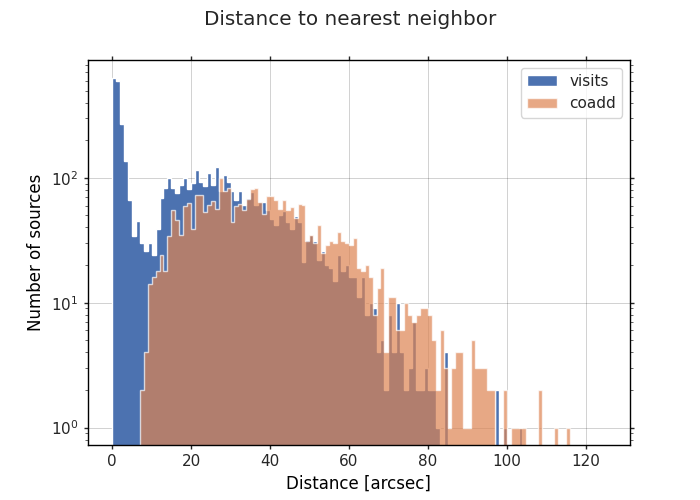

In [8]:
# Distance to nearest neighbor    
def get_hist_bins(data, bin_size, is_list=False):
    
    # get minimum and maximum rounded to integer
    if is_list:
        vmin = np.floor(extr_value(data))
        vmax = np.ceil(extr_value(data, upper=True))
    else:
        vmin = np.floor(np.min(data))
        vmax = np.ceil(np.max(data))
    # generate bin array
    bins = np.arange(vmin, vmax, bin_size)
    return bins

dist_visit = np.asarray(tt_mcat_visits["d_nearest"].to(uu.arcsec).data)
dist_coadd = np.asarray(tt_mcat_coadd["d_nearest"].to(uu.arcsec).data)
vmin = np.floor(np.min([dist_visit.min(),dist_coadd.min()]))
vmax = np.ceil(np.max([dist_visit.max(),dist_coadd.max()]))
bin_size = 1

#bins = int((vmax-vmin) * bin_size)
bins = get_hist_bins(data=[dist_visit, dist_coadd], bin_size=bin_size, is_list=True)

print("range", vmin, vmax)
print("range diff",int(vmax-vmin))
print("bin size", bin_size)
print("number of bins", len(bins))
    
plt.close()
# use custom style sheet
plt.style.use("../mpl_style_sheets/spie_scout_testing.mplstyle")

fig, axs = plt.subplots(figsize=(7, 5), constrained_layout=False)
fig.suptitle("Distance to nearest neighbor")

axs.hist(dist_visit, bins=bins, log=True, histtype="stepfilled", label="visits")
axs.hist(dist_coadd, bins=bins, log=True, histtype="stepfilled", alpha=0.7, label="coadd")

axs.set_xlabel("Distance [arcsec]")
axs.set_ylabel("Number of sources")
axs.legend()

# revert to default style
# prevents crashing of interactive plot display
plt.style.use("default")

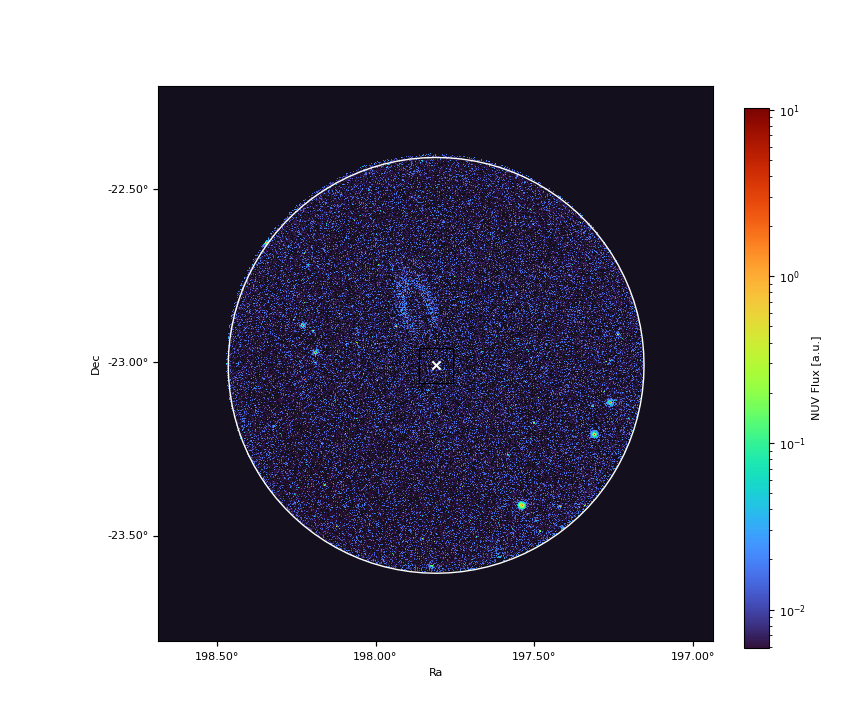

In [11]:
# fits image
coadd_nint_map = gf.dd_maps["coadd"]
# world coordinates
iwcs = wcs.WCS(coadd_nint_map.header)

# cutout
center = SkyCoord(ra=gf.tt_visits["RATileCenter"][0], dec=gf.tt_visits["DECTileCenter"][0], frame="icrs", unit=uu.degree)
#position = SkyCoord(ra=214.67, dec=52.85, frame="icrs", unit=uu.degree)  # 2607375414741434368 PS_GROTH_MOS06
#position = SkyCoord(ra=151.06, dec=2.235, frame="icrs", unit=uu.degree)  # 2605053246158405632 PS_COSMOS_MOS23 - cutout1 
#position = SkyCoord(ra=150.78, dec=2.3965, frame="icrs", unit=uu.degree)  # 2605053246158405632 PS_COSMOS_MOS23 - cutout2
position = center
size = uu.Quantity((0.1, 0.1), uu.deg)
cutout = Cutout2D(coadd_nint_map.data, position, size, wcs=iwcs)

# figure
plt.close("all")
fig = plt.figure(figsize=(8.5, 7.2))
ax = plt.subplot(projection=iwcs)

# plot data
cmap = copy(cm.get_cmap("turbo"))
cmap.set_bad([0.08, 0.06, 0.11])
label_fontsize = 8

# flux data
img = ax.imshow(
    coadd_nint_map.data,
    cmap=cmap,
    norm=LogNorm(),
    origin="lower",
    interpolation="none",
)
# cutout box
cutout.plot_on_original(color="k")
# cutout center coodinate
ax.scatter(position.ra, position.dec, transform=ax.get_transform("world"), c="k", marker="x")
# field of view cut
ax.scatter(center.ra, center.dec, transform=ax.get_transform("world"), c="w", marker="x")
s = SphericalCircle((center.ra, center.dec), dd_cuts_visit["r_fov"] * uu.deg,
                    edgecolor='white', facecolor='none',
                    transform=ax.get_transform('world'))
ax.add_patch(s)

ra = ax.coords["ra"]
dec = ax.coords["dec"]
ra.set_major_formatter("d.dd")
dec.set_major_formatter("d.dd")

ax.set_xlabel("Ra", fontsize=label_fontsize)
ax.set_ylabel("Dec", fontsize=label_fontsize)
ax.xaxis.set_tick_params(labelsize=label_fontsize)
ax.yaxis.set_tick_params(labelsize=label_fontsize)
ax.tick_params(axis="x", labelsize=label_fontsize, bottom=True, top=False)
ax.tick_params(axis="y", labelsize=label_fontsize, left=True, right=False)

# colorbar
cbaxes = fig.add_axes([0.875, 0.1, 0.03, 0.75])
cb = colorbar.Colorbar(
    ax=cbaxes,
    mappable=img,
    orientation="vertical",
)
cb.ax.tick_params(labelsize=label_fontsize)
cb.set_label("NUV Flux [a.u.]", size=label_fontsize)


<SkyCoord (ICRS): (ra, dec) in deg
    [(150.82964363, 2.34686922), (150.72954339, 2.44685115)]>


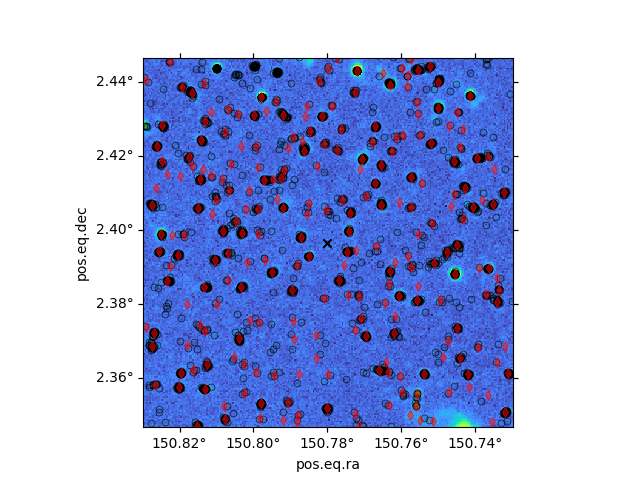

In [10]:
# show cutout
def get_sky_bounds(wcs, data_shape, out_frame="icrs"):
    # corner pixels
    # lower left
    x_ll = 0
    y_ll = 0
    # upper right
    x_ur = data_shape[1]
    y_ur = data_shape[0]
    # conver to world coordinates
    ll = cutout.wcs.pixel_to_world(x_ll, y_ll)
    ur = cutout.wcs.pixel_to_world(x_ur, y_ur)
    # separtion
    #print(ll.separation(ur).deg)
          
    return  SkyCoord([ll.ra, ur.ra], [ll.dec, ur.dec], frame=ll.frame).transform_to(out_frame)


def get_cutout_mask(tt_mcat, cutout_bounds, frame="icrs"):
    x, y = None, None
    if frame=="icrs" or frame=="fk5":
        x = "ra"
        y = "dec"
        mask_cutout_ra = (tt_mcat[x]<=cutout_bounds[0].ra)  * (tt_mcat[x]>=cutout_bounds[1].ra)
        mask_cutout_dec = (tt_mcat[y]>=cutout_bounds[0].dec)  * (tt_mcat[y]<=cutout_bounds[1].dec)
    elif frame=="galctic":
        x = "lon"
        y = "lat"
        mask_cutout_ra = (tt_mcat[x]<=cutout_bounds[0].l)  * (tt_mcat[x]>=cutout_bounds[1].l)
        mask_cutout_dec = (tt_mcat[y]>=cutout_bounds[0].b)  * (tt_mcat[y]<=cutout_bounds[1].b)
    
    return mask_cutout_ra * mask_cutout_dec

cutout_bounds = get_sky_bounds(cutout.wcs, cutout.data.shape)
print(cutout_bounds)
pos_visit_cutout = tt_mcat_visits["ra","dec"][get_cutout_mask(tt_mcat_visits, cutout_bounds, frame="icrs")]
pos_coadd_cutout = tt_mcat_coadd["ra","dec"][get_cutout_mask(tt_mcat_coadd, cutout_bounds, frame="icrs")]


plt.close()
fig = plt.figure()

ax = plt.subplot(projection=cutout.wcs)
ra = ax.coords["ra"]
dec = ax.coords["dec"]
ra.set_major_formatter("d.dd")
dec.set_major_formatter("d.dd")

ax.imshow(
    cutout.data,
    cmap=cmap,
    norm=LogNorm(),
    origin="lower",
    interpolation="none",
    #alpha=0.001
)
ax.scatter(position.ra, position.dec, transform=ax.get_transform("world"), marker="x", color="k")
ax.set_autoscale_on(False)
ax.scatter(
    pos_visit_cutout["ra"],
    pos_visit_cutout["dec"],
    transform=ax.get_transform("world"),
    s=5**2,
    edgecolor=(0,0,0,0.8),
    facecolor=(0,0,0,0.1),
    lw=0.5,
#    alpha=0.2,
    marker="o",
)
ax.scatter(
    pos_coadd_cutout["ra"],
    pos_coadd_cutout["dec"],
    transform=ax.get_transform("world"),
    s=5**2,
    edgecolor=(1,0,0,0.8),
    facecolor=(1,0,0,0.5),
    lw=0.5,
    marker="d",
)

In [10]:
# generate test dataset
np.random.seed(0)
n_samples = 1500
blobs = datasets.make_blobs(n_samples=n_samples, random_state=8)
# Anisotropicly distributed data
random_state = 170
X, y = datasets.make_blobs(n_samples=n_samples, random_state=random_state)
transformation = [[0.6, -0.6], [-0.4, 0.8]]
X_aniso = np.dot(X, transformation)
aniso = (X_aniso, y)
# blobs with varied variances
varied = datasets.make_blobs(
    n_samples=n_samples, cluster_std=[1.0, 2.5, 0.5], random_state=random_state
)


In [ ]:
# bring source position in dataset format
n_sources = len(pos_visit_cutout)
star_data = np.zeros((n_sources,2))
star_data[:,0] = pos_visit_cutout["ra"].data
star_data[:,1] = pos_visit_cutout["dec"].data
star_labels = np.zeros((n_sources,1))
print(star_data.shape, star_labels.shape)
stars = (star_data, star_labels)

In [ ]:
# Set up cluster parameters
default_base = {
    "quantile": 0.3,
    "eps": 0.3,
    "damping": 0.9,
    "preference": -200,
    "n_neighbors": 10,
    "n_clusters": 3,
    "min_samples": 20,
    "xi": 0.05,
    "min_cluster_size": 0.1,
}
dataset_list = [
    (
        varied,
        {
            "eps": 0.18,
            "n_neighbors": 2,
            "min_samples": 5,
            "xi": 0.035,
            "min_cluster_size": 0.2,
        },
    ),
#    (
#        aniso,
#        {
#            "eps": 0.15,
#            "n_neighbors": 2,
#            "min_samples": 20,
#            "xi": 0.1,
#            "min_cluster_size": 0.2,
#        },
#    ),
    (blobs, {}),
    (
        stars,
     {   
         "eps": 0.0001,
         "n_neighbors": 10,
         "min_samples": 5,
         "xi": 0.01,
         "min_cluster_size": 0.2,
         "n_clusters": len(pos_coadd_cutout),
     }
    ),
]

In [ ]:
plt.figure(figsize=(12, 9))
plt.subplots_adjust(
    left=0.02, right=0.98, bottom=0.001, top=0.95, wspace=0.05, hspace=0.01
)
plot_num = 1

for i_dataset, (dataset, algo_params) in enumerate(dataset_list):
    # update parameters with dataset-specific values
    params = default_base.copy()
    params.update(algo_params)

    X, y = dataset

    # normalize dataset for easier parameter selection
    X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X, quantile=params["quantile"])

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(
        X, n_neighbors=params["n_neighbors"], include_self=False
    )
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # ============
    # Create cluster objects
    # ============
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    two_means = cluster.MiniBatchKMeans(n_clusters=params["n_clusters"])
    ward = cluster.AgglomerativeClustering(
        n_clusters=params["n_clusters"], linkage="ward", connectivity=connectivity
    )
    spectral = cluster.SpectralClustering(
        n_clusters=params["n_clusters"],
        eigen_solver="arpack",
        affinity="nearest_neighbors",
    )
    dbscan = cluster.DBSCAN(eps=params["eps"])
    optics = cluster.OPTICS(
        min_samples=params["min_samples"],
        xi=params["xi"],
        min_cluster_size=params["min_cluster_size"],
    )
    affinity_propagation = cluster.AffinityPropagation(
        damping=params["damping"], preference=params["preference"], random_state=0
    )
    average_linkage = cluster.AgglomerativeClustering(
        linkage="average",
        affinity="cityblock",
        n_clusters=params["n_clusters"],
        connectivity=connectivity,
    )
    birch = cluster.Birch(n_clusters=params["n_clusters"])
    gmm = mixture.GaussianMixture(
        n_components=params["n_clusters"], covariance_type="full"
    )

    clustering_algorithms = (
        ("MiniBatch\nKMeans", two_means),
        ("Affinity\nPropagation", affinity_propagation),
        ("MeanShift", ms),
        ("Spectral\nClustering", spectral),
        ("Ward", ward),
        ("Agglomerative\nClustering", average_linkage),
        ("DBSCAN", dbscan),
        ("OPTICS", optics),
        ("BIRCH", birch),
        ("Gaussian\nMixture", gmm),
    )

    for name, algorithm in clustering_algorithms:
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the "
                + "connectivity matrix is [0-9]{1,2}"
                + " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning,
            )
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding"
                + " may not work as expected.",
                category=UserWarning,
            )
            algorithm.fit(X)

        t1 = time.time()
        if hasattr(algorithm, "labels_"):
            y_pred = algorithm.labels_.astype(int)
        else:
            y_pred = algorithm.predict(X)

        plt.subplot(len(dataset_list), len(clustering_algorithms), plot_num)
        if i_dataset == 0:
            plt.title(name, size=12)

        colors = np.array(
            list(
                islice(
                    cycle(
                        [
                            "#377eb8",
                            "#ff7f00",
                            "#4daf4a",
                            "#f781bf",
                            "#a65628",
                            "#984ea3",
                            "#999999",
                            "#e41a1c",
                            "#dede00",
                        ]
                    ),
                    int(max(y_pred) + 1),
                )
            )
        )
        # add black color for outliers (if any)
        colors = np.append(colors, ["#000000"])
        plt.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred])

        plt.xlim(-2.5, 2.5)
        plt.ylim(-2.5, 2.5)
        plt.xticks(())
        plt.yticks(())
        plt.text(
            0.99,
            0.01,
            ("%.2fs" % (t1 - t0)).lstrip("0"),
            transform=plt.gca().transAxes,
            size=8,
            horizontalalignment="right",
        )
        plot_num += 1

In [12]:
def mscatter(x, y, ax=None, m=None, **kw):
    """
    Wrapper for matplotlib.pyplot.scatter() that allows marker to be a list.
    From https://stackoverflow.com/a/52303895/13115938
    """
    if not ax: ax=plt.gca()
    sc = ax.scatter(x,y,**kw)
    if (m is not None) and (len(m)==len(x)):
        paths = []
        for marker in m:
            if isinstance(marker, mmarkers.MarkerStyle):
                marker_obj = marker
            else:
                marker_obj = mmarkers.MarkerStyle(marker)
            path = marker_obj.get_path().transformed(
                        marker_obj.get_transform())
            paths.append(path)
        sc.set_paths(paths)
    return sc

def draw_sizebar(ax, length, label, loc="lower right", fontsize=10, frameon=False, label_top=False):
    """
    Draw a horizontal bar with given length in data coordinates,
    with a label underneath.
    """
    fontprops = fm.FontProperties(size=fontsize)
    asb = AnchoredSizeBar(
        ax.transData,
        length,
        label,
        loc=loc,
        pad=0.1, borderpad=0.8, sep=5,
        frameon=frameon,
        label_top=label_top,
        fontproperties=fontprops,
    )
    ax.add_artist(asb)

In [13]:
def compute_cluster(data, input_params, algorithm, normalize=True):
    # ============
    # Setup
    # ============

    # update parameters with dataset-specific values
    default_params = {
        "quantile": 0.3,
        "bandwidth": None,
        "bin_seeding": False,
        "min_bin_freq": 1,
        "cluster_all": True,
        "n_jobs": None,
        "eps": 0.3,
        "damping": 0.9,
        "preference": -200,
        "n_neighbors": 10,
        "n_clusters": 3,
        "min_samples": 20,
        "max_eps": np.inf,
        "xi": 0.05,
        "min_cluster_size": 0.1,
        "distance_threshold": 0.005,
        "birch_n_clusters": None,
    }
    algo_params = input_params
    params = default_params.copy()
    params.update(algo_params)

    # (x,y) data
    X = data

    # normalize dataset for easier parameter selection
    if normalize:
        X = StandardScaler().fit_transform(X)

    # estimate bandwidth for mean shift
    if params["bandwidth"] is None:
        bandwidth = cluster.estimate_bandwidth(X, quantile=params["quantile"])
    else:
        bandwidth = params["bandwidth"]
    print((bandwidth * uu.degree).to(uu.arcsec))

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(
        X, n_neighbors=params["n_neighbors"], include_self=False
    )
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # ============
    # Create cluster objects
    # ============
    if algo_key == "ms":
        ms = cluster.MeanShift(
            bandwidth=bandwidth,
            bin_seeding=params["bin_seeding"],
            min_bin_freq=params["min_bin_freq"],
            cluster_all=params["cluster_all"],
            n_jobs=params["n_jobs"],
        )
        algo_name = "MeanShift"
        algorithm = ms
    elif algo_key == "two_means":
        two_means = cluster.MiniBatchKMeans(n_clusters=params["n_clusters"])
        algo_name = "MiniBatch\nKMeans"
        algorithm = two_means
    elif algo_key == "ward":
        ward = cluster.AgglomerativeClustering(
            n_clusters=None,
            distance_threshold=params["distance_threshold"],
            linkage="ward",
            connectivity=connectivity
        )
        algo_name = "Ward"
        algorithm = ward
    elif algo_key == "spectral":
        spectral = cluster.SpectralClustering(
            n_clusters=params["n_clusters"],
            eigen_solver="arpack",
            affinity="nearest_neighbors",
        )
        algo_name = "Spectral\nClustering"
        algorithm = spectral
    elif algo_key == "dbscan":
        dbscan = cluster.DBSCAN(eps=params["eps"])
        algo_name = "DBSCAN"
        algorithm = dbscan
    elif algo_key == "optics":
        optics = cluster.OPTICS(
            min_samples=params["min_samples"],
            max_eps=params["max_eps"],
            xi=params["xi"],
            min_cluster_size=params["min_cluster_size"],
        )
        algo_name = "OPTICS"
        algorithm = optics
    elif algo_key == "hdbscan":
        hdbscan_clstr = hdbscan.HDBSCAN(
            min_cluster_size=params["min_cluster_size"],
            min_samples=params["min_samples"],
            cluster_selection_epsilon=params["eps"],
        )
        algo_name = "HDBSCAN"
        algorithm = hdbscan_clstr
    elif algo_key == "affinity_propagation":
        affinity_propagation = cluster.AffinityPropagation(
            damping=params["damping"],
            preference=params["preference"],
            random_state=0
        )
        algo_name = "Affinity\nPropagation"
        algorithm = affinity_propagation
    elif algo_key == "average_linkage":
        average_linkage = cluster.AgglomerativeClustering(
            linkage="average",
            affinity="cityblock",
            n_clusters=params["n_clusters"],
            connectivity=connectivity,
        )
        algo_name = "Agglomerative\nClustering"
        algorithm = average_linkage
    elif algo_key == "birch":
        birch = cluster.Birch(
            threshold=params["distance_threshold"],
            n_clusters=params["birch_n_clusters"],
            branching_factor=2,
        )
        algo_name = "BIRCH"
        algorithm = birch
    elif algo_key == "gmm":
        gmm = mixture.GaussianMixture(
            n_components=params["n_clusters"],
            covariance_type="full"
        )
        algo_name = "Gaussian\nMixture"
        algorithm = gmm

    # ============
    # Compute cluster
    # ============
    t0 = time.time()

    # catch warnings related to kneighbors_graph
    with warnings.catch_warnings():
        warnings.filterwarnings(
            "ignore",
            message="the number of connected components of the "
            + "connectivity matrix is [0-9]{1,2}"
            + " > 1. Completing it to avoid stopping the tree early.",
            category=UserWarning,
        )
        warnings.filterwarnings(
            "ignore",
            message="Graph is not fully connected, spectral embedding"
            + " may not work as expected.",
            category=UserWarning,
        )
        algorithm.fit(X)

    t1 = time.time()
    comp_time = t1 - t0
    
    if hasattr(algorithm, "labels_"):
        y_pred = algorithm.labels_.astype(int)
    else:
        y_pred = algorithm.predict(X)        
    
    return (algorithm, y_pred, algo_name, comp_time)
    
def show_cluster(data, algorithm, normalize=False):
    
    X = data
    _, y_pred, algo_name, comp_time = algorithm

    # ============
    # Plot
    # ============
    fig, ax = plt.subplots(figsize=(6,6), tight_layout=True)
    fig.suptitle(algo_name)

    #color cycler
    colors = np.array(
        list(
            islice(
                cycle(
                    [
                        "#377eb8",
                        "#ff7f00",
                        "#4daf4a",
                        "#f781bf",
                        "#a65628",
                        "#984ea3",
                        "#999999",
                        "#e41a1c",
                        "#dede00",
                    ]
                ),
                int(max(y_pred) + 1),
            )
        )
    )
    colors = np.append(colors, ["#000000"]) # black for outliers (if any)
    # marker cycler
    markers = np.array(
        list(
            islice(
                cycle(
                    [    
                        "s",
                        "v",
                        "^",
                        "h",
                        "+",
                        "p",
                        "*",
                        "<",
                        ">",
                        ".",
                    ]
                ),
                int(max(y_pred) + 1),
            )
        )
    )
    markers = np.append(markers, ["x"]) # x for outliers (if any)
    
    # draw
    mscatter(X[:, 0], X[:, 1], ax=ax, s=10, c=colors[y_pred], m=markers[y_pred], alpha=0.2)
    #ax.scatter(X[:, 0], X[:, 1], s=10, color=colors[y_pred], alpha=0.2)
    paths = list()
    
    if normalize:
        ax.set_xlim(-2.5, 2.5)
        ax.set_ylim(-2.5, 2.5)
        ax.set_xticks(())
        ax.set_yticks(())
    
    # add computation time info
    ax.text(
        0.99,
        0.01,
        ("%.2fs" % comp_time).lstrip("0"),
        transform=plt.gca().transAxes,
        size=8,
        horizontalalignment="right",
    )

0.001388888888888889 <class 'numpy.float64'>
5.0 arcsec


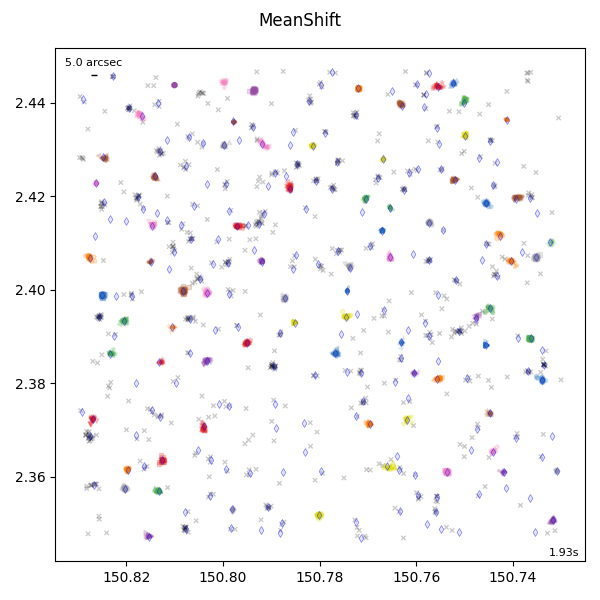

In [14]:
# test clsutering
plt.close("all")

r_cluster = (5.0 * uu.arcsec).to(uu.degree).value
print(r_cluster, type(r_cluster))

use_cutout = True
if use_cutout:
    n_sources = len(pos_visit_cutout)
    n_sources_coadd = len(pos_coadd_cutout)
    pos_data = np.zeros((n_sources,2))
    pos_data[:,0] = pos_visit_cutout["ra"].data
    pos_data[:,1] = pos_visit_cutout["dec"].data
else:
    n_sources = len(tt_mcat_visits)
    n_sources_coadd = len(tt_mcat_coadd)
    pos_data = np.zeros((n_sources,2))
    pos_data[:,0] = tt_mcat_visits["ra"].data
    pos_data[:,1] = tt_mcat_visits["dec"].data

params = {
    "quantile": 0.01,
    "bandwidth": r_cluster,
    "bin_seeding": True,
    "min_bin_freq": 10,
    "cluster_all": False,
    "n_jobs": -1,
    "damping": 0.9,
    "preference": -0.00002,        
    "n_neighbors": 30,
    "n_clusters": 10,
    "eps": float(r_cluster),
    "min_samples": 2,
    "max_eps": r_cluster,
    "xi": 0.001,
    "min_cluster_size": 15,
    "distance_threshold": r_cluster,
    "birch_n_clusters": None,
}

# available clustering algorithms
"""

         NAME                        KEY                    RETURNS CENTROID              WITHOUT N_CLUSTER          ACCEPTS R_CLUSTER

    MiniBatch KMeans            two_means                         yes                             x                           x
    Affinity Propagation        affinity_propagation              yes                            yes                          x  (requires "preference")
->  MeanShift                   ms                                yes                            yes                         yes (via "bandwidth")
    Spectral Clustering         spectral                           x                              x                           x
    Ward                        ward                               x                             yes                         yes
    Agglomerative Clustering    average_linkage                    x                              x                           x
    DBSCAN                      dbscan                             x                             yes                         yes
    OPTICS                      optics                             x                             yes                         yes
    HDBSCAN                     hdbscan                            x                             yes                         yes
->  BIRCH                       birch                             yes                            yes                         yes
    Gaussian Mixture            gmm                               yes                             x                           x
    """
algo_key = "ms"
algorithm = compute_cluster(pos_data, params, algo_key, normalize=False)


show_cluster(pos_data, algorithm, normalize=False)
ax = plt.gca()
ax.scatter(
    pos_coadd_cutout["ra"] if use_cutout else tt_mcat_coadd["ra"],
    pos_coadd_cutout["dec"] if use_cutout else tt_mcat_coadd["dec"],
    s=4**2,
    edgecolor=(0,0,1,0.5),
    facecolor=(0,0,1,0.1),
    lw=0.5,
    marker="d",
    zorder=1,
)
#ax.scatter(algorithm[0].cluster_centers_[:,0],algorithm[0].cluster_centers_[:,1],s=4**2,marker="x",zorder=1,color="r")
ax.invert_xaxis()
r_cluster_arcsec = (r_cluster*uu.deg).to(uu.arcsec)
draw_sizebar(ax, r_cluster, f"{r_cluster_arcsec:1.1f}", loc="upper left", fontsize=8, frameon=False, label_top=True)

In [15]:
tt_clusters = Table(np.asarray([pos_data[:,0], pos_data[:,1], algorithm[0].labels_]).T, names=["ra", "dec", "label"])
tt_clusters["ra"].unit = uu.deg
tt_clusters["dec"].unit = uu.deg
tt_clusters_group = tt_clusters.group_by("label")
print(tt_clusters)

        ra                dec         label
       deg                deg              
------------------ ------------------ -----
150.81515226025803 2.3471458536575738  68.0
150.78000374449815 2.3520935869386066  35.0
150.80799807805647 2.3485529188560044  -1.0
150.80297767857263  2.355643072954191  -1.0
150.79792012420467 2.3533701230285664  24.0
150.73175538539752 2.3508578006768714  32.0
150.82722509245625  2.358238708778718  -1.0
150.81991066933446  2.357183170638516  33.0
150.81366362874456  2.357043209529198   2.0
 150.7414500186647  2.360924034280166  59.0
150.73090726895032 2.3611228022160433  69.0
150.81936289393497 2.3613090063411257   1.0
150.81268479719145 2.3634774515158927  70.0
 150.7438682266212  2.365845241879268  75.0
150.76521193938606  2.362057439760211  62.0
150.78187971499108  2.366507202012412  -1.0
150.75379205530385 2.3609802431832643  30.0
150.81066146981763 2.3714822241205975  -1.0
150.74450906630918 2.3734933585208027  76.0
               ...              

In [16]:
center_sep_list = list()
for label, clstr in zip(tt_clusters_group.groups.keys, tt_clusters_group.groups):
    label = int(label["label"])
    clstr_center = SkyCoord(algorithm[0].cluster_centers_[label,0], algorithm[0].cluster_centers_[label,1], unit=uu.deg, frame="icrs")
    pos = SkyCoord(clstr["ra"], clstr["dec"], frame="icrs")
    clstr["center_sep"] = clstr_center.separation(pos)
    center_sep_list.append(clstr["center_sep"])

tt_new = hstack([tt_clusters_group["ra"],tt_clusters_group["dec"],tt_clusters_group["label"],vstack(center_sep_list)])
print(tt_new)

        ra                dec         label       center_sep      
       deg                deg                        deg          
------------------ ------------------ ----- ----------------------
150.80799807805647 2.3485529188560044  -1.0    0.07563493975269472
150.80297767857263  2.355643072954191  -1.0    0.06740987948024253
150.82722509245625  2.358238708778718  -1.0    0.08728552887956552
150.78187971499108  2.366507202012412  -1.0    0.04401268808739817
150.81066146981763 2.3714822241205975  -1.0    0.06695989213598245
150.76265217700683 2.3758566728670374  -1.0   0.023680609552846094
150.74982957198154  2.380641893924022  -1.0   0.013689299402137705
150.77142293738154 2.3819732900514916  -1.0    0.02673540039026698
 150.8040605140983  2.392444590944251  -1.0    0.05643684753588055
150.80736373110707  2.394048893407767  -1.0    0.05971149655920517
150.82521013784947  2.394710091458308  -1.0    0.07754425541124432
150.74906569576967 2.3921700641027526  -1.0  0.002461560470706

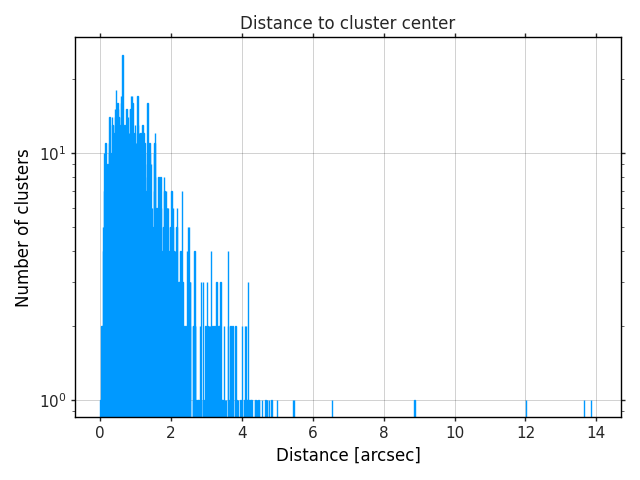

In [17]:
# Distance to cluster center

# use custom style sheet
plt.style.use("../mpl_style_sheets/spie_scout_testing.mplstyle")
plt.close()
plt.figure(tight_layout=True)
sep_data = tt_new["center_sep"].to(uu.arcsec).value[tt_new["center_sep"].to(uu.arcsec).value<15]
_ = plt.hist(
    sep_data,
    log=True,
    bins=get_hist_bins(sep_data,bin_size=0.01, is_list=False),
    facecolor=(0., 0.6, 1., 0.4),
    edgecolor=(0., 0.6, 1., 1.0)
)
plt.title("Distance to cluster center")
plt.xlabel("Distance [arcsec]")
plt.ylabel("Number of clusters")
#plt.xscale("log")

# revert to default style
# prevents crashing of interactive plot display
plt.style.use("default")

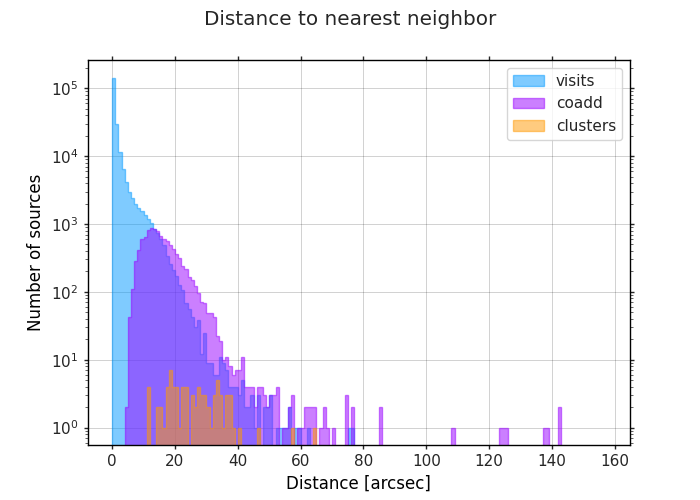

In [18]:
# Distance to nearest neighbor
dist_visit = np.asarray(tt_mcat_visits["d_nearest"].to(uu.arcsec).data)
dist_coadd = np.asarray(tt_mcat_coadd["d_nearest"].to(uu.arcsec).data)
pos_clstr = SkyCoord(algorithm[0].cluster_centers_[:,0], algorithm[0].cluster_centers_[:,1], unit=uu.deg, frame="icrs")
_, dist_clstr, _ = pos_clstr.match_to_catalog_sky(pos_clstr, nthneighbor=2)
dist_clstr = dist_clstr.to(uu.arcsec).data

bin_size = 1
bins = get_hist_bins(data=[dist_visit, dist_coadd, dist_clstr], bin_size=bin_size, is_list=True)
    
plt.close()
# use custom style sheet
plt.style.use("../mpl_style_sheets/spie_scout_testing.mplstyle")

fig, axs = plt.subplots(figsize=(7, 5), constrained_layout=False)
fig.suptitle("Distance to nearest neighbor")

axs.hist(dist_visit, bins=bins, log=True, histtype="stepfilled", alpha=0.5, label="visits", facecolor=(0., 0.6, 1., 0.0005), edgecolor=(0., 0.6, 1., 1.0))
axs.hist(dist_coadd, bins=bins, log=True, histtype="stepfilled", alpha=0.5, label="coadd", facecolor=(0.6, 0., 1., 0.0005), edgecolor=(0.6, 0., 1., 1.0))
axs.hist(dist_clstr, bins=bins, log=True, histtype="stepfilled", alpha=0.5, label="clusters", facecolor=(1., 0.6, 0., 0.0005), edgecolor=(1., 0.6, 0., 1.0))

axs.set_xlabel("Distance [arcsec]")
axs.set_ylabel("Number of sources")
axs.legend()

# revert to default style
# prevents crashing of interactive plot display
plt.style.use("default")